# Assignment 4

Step 1: Running the data and summary


Shape: (33212, 17)

Data types:
 age                 int64
workclass          object
fnlwgt              int64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
random_string      object
hashed_id          object
dtype: object

Missing values per column:
 occupation        3910
workclass         1873
education-num     1638
native-country     591
age                  0
education            0
marital-status       0
relationship         0
fnlwgt               0
race                 0
sex                  0
capital-loss         0
capital-gain         0
hours-per-week       0
income               0
random_string        0
hashed_id            0
dtype: int64

Numeric summary stats:
                   count           mean            std

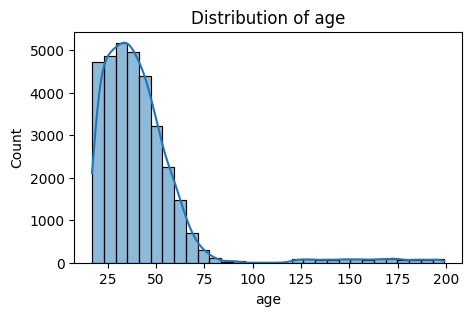

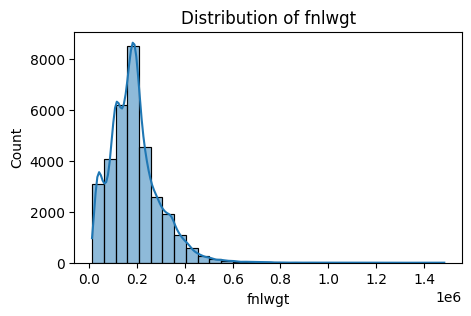

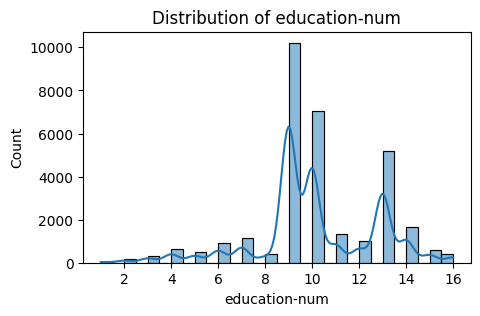

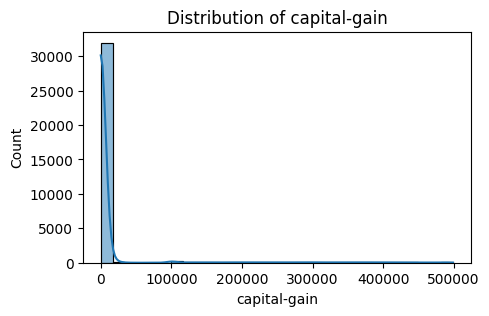

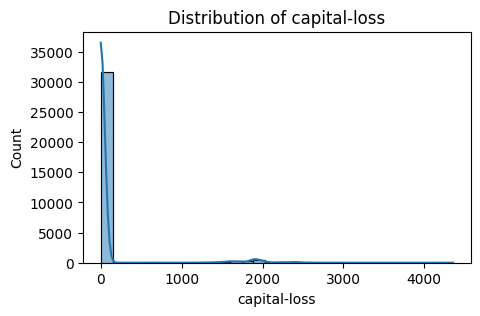

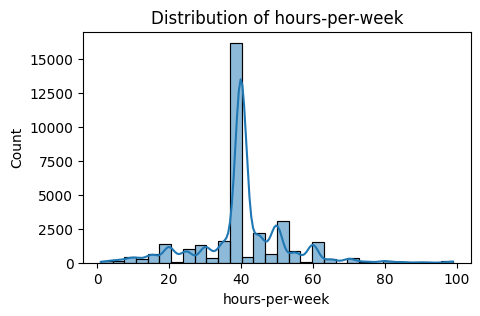

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

df = pd.read_csv("raw data_d80b79f9-2fbb-4f11-bdeb-47c41e7cbcf5.csv")

# --- Basic summary ---
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)

# Count missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing_summary

# Describe numeric columns
print("\nNumeric summary stats:\n", df.describe().T)

# Numeric histograms
for c in num_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[c], kde=True, bins=30)
    plt.title(f"Distribution of {c}")
    plt.show()

Step 2: Data Issues

In [9]:
# --- Check duplicates ---
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# --- Check for constant or irrelevant columns ---
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
print("Constant / single-valued columns:", constant_cols)

# --- Identify potential ID columns (too unique) ---
id_like_cols = [c for c in df.columns if df[c].nunique() > 0.95 * len(df)]
print("Possible ID-like columns:", id_like_cols)

# --- Check inconsistent text formatting (example: trailing spaces, case) ---
for c in df.select_dtypes(include="object"):
    sample = df[c].dropna().astype(str).head(5).tolist()
    if any((" " in s.strip() and (s != s.strip() or s.lower() != s)) for s in sample):
        print(f"⚠️ Column '{c}' may have inconsistent formatting:", sample)

# --- Detect suspicious numeric ranges (example: age, hours_per_week if present) ---
if "age" in df.columns:
    bad_age = df[(df["age"] < 0) | (df["age"] > 120)]
    print(f"Suspicious age values: {len(bad_age)}")

if "hours_per_week" in df.columns:
    bad_hours = df[(df["hours_per_week"] < 0) | (df["hours_per_week"] > 100)]
    print(f"Suspicious hours_per_week values: {len(bad_hours)}")

# --- Show summary of issues found ---
print("\n--- SUMMARY ---")
print(f"Duplicates: {duplicate_count}")
print(f"Constant columns: {constant_cols}")
print(f"ID-like columns: {id_like_cols}")


Number of duplicate rows: 651
Constant / single-valued columns: []
Possible ID-like columns: ['random_string', 'hashed_id']
Suspicious age values: 995

--- SUMMARY ---
Duplicates: 651
Constant columns: []
ID-like columns: ['random_string', 'hashed_id']
Formatting inconsistencies checked above.


Step 3: Imputed Dataset

In [14]:
from sklearn.impute import SimpleImputer

# Load your working dataset (from previous cleaning step)
df = pd.read_csv("raw data_d80b79f9-2fbb-4f11-bdeb-47c41e7cbcf5.csv")

# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include="object").columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# --- Numeric Imputation (median) ---
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# --- Categorical Imputation (most frequent) ---
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("\n✅ Missing values filled.")
print(df.isna().sum().sum())

# Save this as cleaned (no missing values)
df.to_csv("step3_imputed.csv", index=False)
print("Saved: step3_imputed.csv")


Numeric columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income', 'random_string', 'hashed_id']

✅ Missing values filled.
0
Saved: step3_imputed.csv


Step 4: Handling outliers

Potential outliers per numeric column:
  age: 1088 outliers (range = [-3.50, 80.50])
  fnlwgt: 1000 outliers (range = [-61473.75, 416720.25])
  education-num: 1166 outliers (range = [4.50, 16.50])
  capital-gain: 3655 outliers (range = [0.00, 0.00])
  capital-loss: 1550 outliers (range = [0.00, 0.00])
  hours-per-week: 9206 outliers (range = [32.50, 52.50])

✅ Outliers capped within IQR bounds.
✅ age: all values within normal range.
✅ fnlwgt: all values within normal range.
✅ education-num: all values within normal range.
✅ capital-gain: all values within normal range.
✅ capital-loss: all values within normal range.
✅ hours-per-week: all values within normal range.


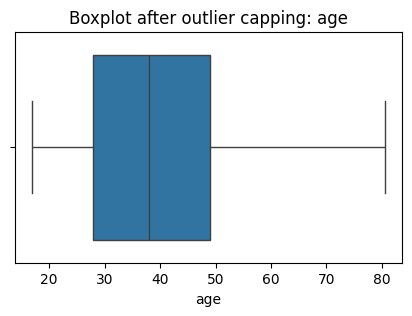

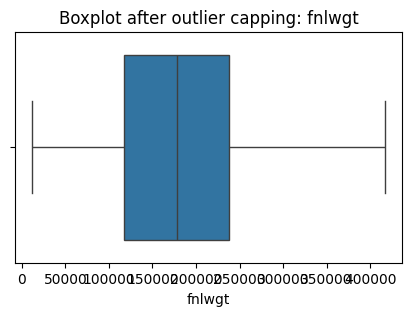

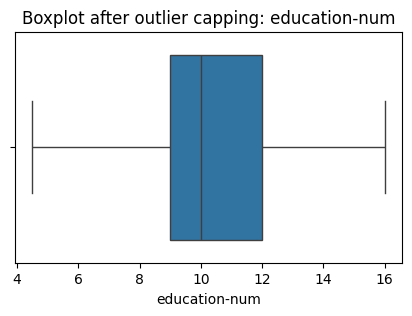

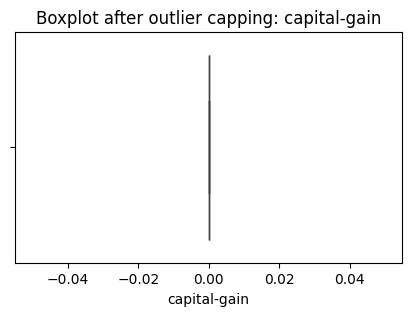

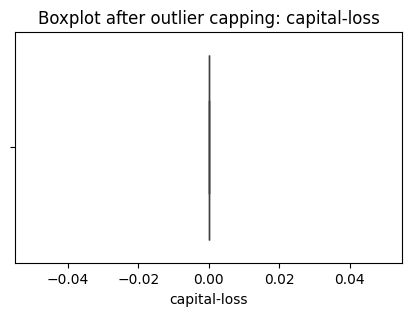

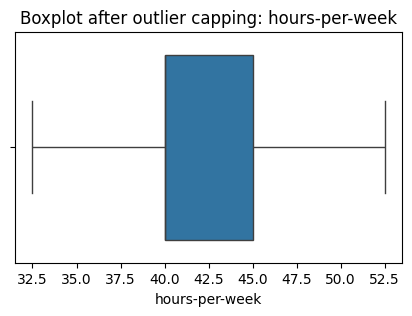


✅ Final cleaned dataset saved as step4_no_missing_no_outliers.csv


In [15]:
# Load the imputed dataset (output from Step 3)
df_clean = pd.read_csv("step3_imputed.csv")

# --- Define IQR-based bounds ---
def iqr_bounds(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return lower, upper

# --- Detect outliers ---
print("Potential outliers per numeric column:")
for col in df_clean.select_dtypes(include=[np.number]):
    lower, upper = iqr_bounds(df_clean[col])
    n_out = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
    print(f"  {col}: {n_out} outliers (range = [{lower:.2f}, {upper:.2f}])")

# --- Treat outliers (capping at IQR boundaries) ---
for col in df_clean.select_dtypes(include=[np.number]):
    lower, upper = iqr_bounds(df_clean[col])
    df_clean[col] = np.clip(df_clean[col], lower, upper)

print("\n✅ Outliers capped within IQR bounds.")

# --- Verify again ---
for col in df_clean.select_dtypes(include=[np.number]):
    lower, upper = iqr_bounds(df_clean[col])
    n_out = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
    if n_out > 0:
        print(f"⚠️ {col}: still {n_out} extreme values.")
    else:
        print(f"✅ {col}: all values within normal range.")

# Optional: visualize a few boxplots
for col in df_clean.select_dtypes(include=[np.number]).head(5):
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot after outlier capping: {col}")
    plt.show()

# --- Save final dataset (no missing values + outliers treated) ---
df_clean.to_csv("step4_no_missing_no_outliers.csv", index=False)
print("\n✅ Final cleaned dataset saved as step4_no_missing_no_outliers.csv")


Step 5: Handling formatting inconsistencies

In [17]:
df = pd.read_csv("step4_no_missing_no_outliers.csv")

def to_snake_case(s):
    s = re.sub(r"[^\w]+", "_", s.strip())
    s = re.sub(r"__+", "_", s)
    return s.strip("_").lower()

df.columns = [to_snake_case(c) for c in df.columns]

for c in df.select_dtypes(include="object"):
    sample = df[c].dropna().astype(str).head(10).tolist()
    if any((s != s.strip() or s.lower() != s or "  " in s) for s in sample):
        print(f"Possible formatting issues in '{c}': {sample}")

for c in df.select_dtypes(include="object"):
    df[c] = df[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True).str.lower()

for c in df.columns:
    if df[c].dtype == "object":
        temp = df[c].str.replace(",", "", regex=False).str.replace("$", "", regex=False)
        if temp.str.match(r"^-?\d+(\.\d+)?$").mean() > 0.8:
            df[c] = pd.to_numeric(temp, errors="coerce")

bool_map = {"yes": 1, "no": 0, "true": 1, "false": 0}
for c in df.select_dtypes(include="object"):
    if set(df[c].dropna().unique()) <= set(bool_map.keys()):
        df[c] = df[c].map(bool_map)

print("Formatting inconsistencies detected and corrected.")
df.to_csv("step5_formatted.csv", index=False)
print("Saved: step5_formatted.csv")


Possible formatting issues in 'workclass': ['Private', 'Private', 'Private', 'Private', 'Private', 'State-gov', 'Private', ' Private ', 'Self-emp-not-inc', 'Private']
Possible formatting issues in 'education': ['hs-grad', 'SOME-COLLEGE', 'Some-college', '9th', 'HS-grad', 'some-college', 'HS-GRAD', 'HS-grad', 'hs-grad', 'HS-grad']
Possible formatting issues in 'marital_status': ['Never-married', 'Divorced', 'NEVER-MARRIED', 'Never-married', ' Never-married ', 'Never-married', ' Married-civ-spouse ', 'Divorced', 'Married-civ-spouse', 'Married-civ-spouse']
Possible formatting issues in 'occupation': ['Other-service', 'Adm-clerical', 'Sales', 'Priv-house-serv', 'Machine-op-inspct', ' adm-clerical ', 'Machine-op-inspct', 'Craft-repair', 'Craft-repair', 'Farming-fishing']
Possible formatting issues in 'relationship': ['Other-relative', 'Unmarried', 'Not-in-family', 'Not-in-family', 'Not-in-family', 'Not-in-family', 'Husband', 'Unmarried', ' Husband ', 'Husband']
Possible formatting issues in

Step 6: Noise handling

In [18]:
# Load the formatted dataset
df = pd.read_csv("step5_formatted.csv")

# --- Remove constant columns (no variation) ---
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
if constant_cols:
    print("Dropping constant columns:", constant_cols)
    df.drop(columns=constant_cols, inplace=True)

# --- Remove ID-like or high-uniqueness columns ---
id_like_cols = [c for c in df.columns if df[c].nunique() > 0.95 * len(df)]
if id_like_cols:
    print("Dropping ID-like columns:", id_like_cols)
    df.drop(columns=id_like_cols, inplace=True)

# --- Remove columns with mostly missing (should be none by now, but safe check) ---
high_missing_cols = [c for c in df.columns if df[c].isna().mean() > 0.8]
if high_missing_cols:
    print("Dropping mostly-missing columns:", high_missing_cols)
    df.drop(columns=high_missing_cols, inplace=True)

# --- Optional: Drop text-heavy or uninformative fields (like names, notes, addresses) ---
text_like_cols = [c for c in df.columns if df[c].dtype == "object" and df[c].str.len().mean() > 50]
if text_like_cols:
    print("Dropping free-text columns (likely noisy):", text_like_cols)
    df.drop(columns=text_like_cols, inplace=True)

# --- Summary of remaining columns ---
print("\n Remaining columns after cleaning:", len(df.columns))
print(df.columns.tolist())

df.to_csv("step6_relevant_features.csv", index=False)
print("\nSaved: step6_relevant_features.csv")


Dropping constant columns: ['capital_gain', 'capital_loss']
Dropping ID-like columns: ['random_string', 'hashed_id']

 Remaining columns after cleaning: 13
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'hours_per_week', 'native_country', 'income']

Saved: step6_relevant_features.csv


Step 7: Feature engineering

In [21]:
df = pd.read_csv("step5_formatted.csv")
# Age band
if "age" in df.columns:
    df["age_band"] = pd.cut(
        df["age"],
        bins=[-np.inf, 25, 35, 45, 55, 65, np.inf],
        labels=["<=25", "26-35", "36-45", "46-55", "56-65", "65+"]
    )

# Weekly work-hour category
if "hours_per_week" in df.columns:
        df["work_hours_band"] = pd.cut(
            df["hours_per_week"],
            bins=[-np.inf, 20, 35, 45, 60, np.inf],
            labels=["<=20", "21-35", "36-45", "46-60", "60+"]
        )  

print("Derived features created:")
print([c for c in df.columns if c not in pd.read_csv('step5_formatted.csv').columns])

df.to_csv("step7_engineered.csv", index=False)
print("Saved: step7_engineered.csv")


Derived features created:
['age_band', 'work_hours_band']
Saved: step7_engineered.csv


Step 8: Normalization

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df = pd.read_csv("step7_engineered.csv")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns to scale:", num_cols)


scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

print("Numeric columns standardized using StandardScaler (mean = 0, std = 1).")

df_scaled.to_csv("step8_scaled.csv", index=False)
print("Saved: step8_scaled.csv")


Numeric columns to scale: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Numeric columns standardized using StandardScaler (mean = 0, std = 1).
Saved: step8_scaled.csv


In [36]:
df = pd.read_csv("step8_scaled.csv")
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,random_string,hashed_id,age_band,work_hours_band
0,-0.977333,private,-0.388775,hs-grad,-0.465875,never-married,other-service,other-relative,asian-pac-islander,male,0.0,0.0,1.825037,united-states,<=50k,vuvdctsd,a92aff61e7514b67804af2bf2e49c4bc,<=25,46-60
1,0.143170,private,-0.533389,some-college,-0.049653,divorced,adm-clerical,unmarried,white,female,0.0,0.0,-0.517571,united-states,<=50k,nrkmpinc,21cfd6f91910433c89b9b30372f4b336,36-45,36-45
2,2.680778,private,0.933557,some-college,-0.049653,never-married,sales,not-in-family,white,female,0.0,0.0,-0.194453,united-states,<=50k,bfdkyddp,dd7e979f9ba940af92186a3eaaaa2a7e,65+,36-45
3,-0.186390,private,0.536789,9th,-2.130764,never-married,priv-house-serv,not-in-family,white,female,0.0,0.0,-1.406147,el-salvador,<=50k,xeiuhlqw,09f5552dd2da482da107ff052bef8474,36-45,21-35
4,-0.318214,private,0.007982,hs-grad,-0.465875,never-married,machine-op-inspct,not-in-family,white,male,0.0,0.0,-0.194453,united-states,<=50k,rhwrhbgk,42b77d19e1dd4812af3012993bf06171,26-35,36-45


Building modeling matrix


Numeric matrix shape: (33212, 6)
Components to reach ≥95% variance: 4


,component,explained_variance_ratio,cumulative_variance_ratio
0,1,0.308836,0.308836
1,2,0.254371,0.563207
2,3,0.233386,0.796592
3,4,0.203408,1.000000
4,5,0.000000,1.000000
5,6,0.000000,1.000000


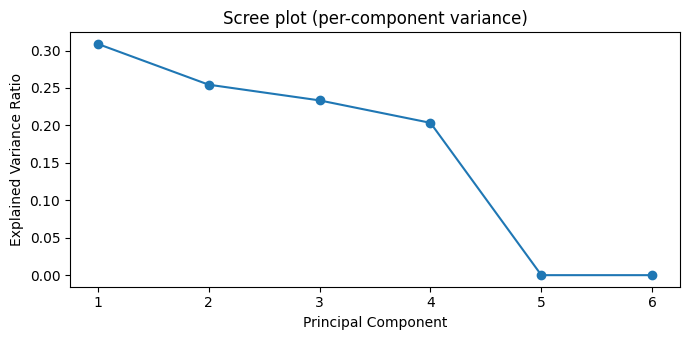

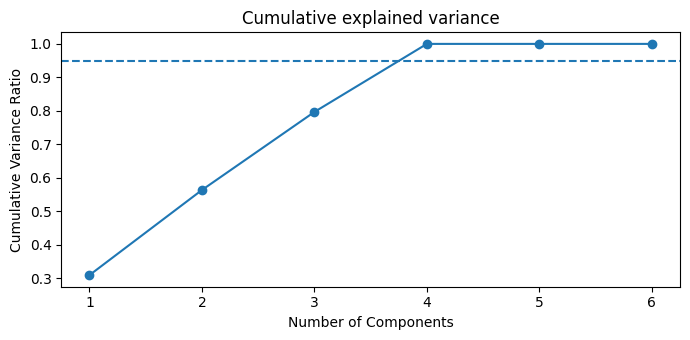

Scores matrix (Z) shape: (33212, 4)


,PC1,PC2,PC3,PC4
0,0.582412,0.601494,-0.749560,1.841544
1,-0.147411,-0.633650,-0.239636,-0.307699
2,0.671634,-0.755506,2.559840,-0.723681
3,-2.390676,-0.713798,0.677238,0.395978
4,-0.533257,-0.060609,-0.118793,0.232437
5,-0.157225,-0.340947,-0.828436,0.070643
6,-0.405800,-0.387937,-0.400542,0.279953
7,-0.374721,-0.255703,0.176591,0.155046
8,0.499533,-1.758734,0.504445,0.003242
9,-1.301137,-0.275648,0.262078,-0.724243


In [27]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------- Load & keep only numeric features (drop target if detected) ----------
df = pd.read_csv("step8_scaled.csv")

candidates = [c for c in df.columns if re.search(r"income|salary|earn|wage|pay|income_cat|income_level|>50k|<=50k", c, re.I)]
TARGET_COL = candidates[0] if candidates else None

num_df = df.select_dtypes(include=[np.number]).copy()
if TARGET_COL is not None and TARGET_COL in num_df.columns:
    num_df = num_df.drop(columns=[TARGET_COL])

X = num_df.to_numpy(dtype=np.float32)
features = num_df.columns.tolist()
print("Numeric matrix shape:", X.shape)

# ---------- Fit "full" PCA to inspect explained variance ----------
pca_full = PCA(random_state=42)
Z_full = pca_full.fit_transform(X)
evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

k95 = int(np.searchsorted(cum, 0.95) + 1)
print("Components to reach ≥95% variance:", k95)

explained = pd.DataFrame({
    "component": np.arange(1, len(evr)+1),
    "explained_variance_ratio": evr,
    "cumulative_variance_ratio": cum
})
display(explained.head(20))  # show first 20 rows (adjust as you like)

# ---------- Plots ----------
plt.figure(figsize=(7,3.5))
plt.plot(np.arange(1, len(evr)+1), evr, marker="o")
plt.title("Scree plot (per-component variance)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3.5))
plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
plt.axhline(0.95, ls="--")
plt.title("Cumulative explained variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.tight_layout()
plt.show()

# ---------- Fit PCA with just enough components for ≥95% variance ----------
pca_95 = PCA(n_components=k95, random_state=42)
Z = pca_95.fit_transform(X)

pc_names = [f"PC{i}" for i in range(1, Z.shape[1]+1)]
Z_df = pd.DataFrame(Z, columns=pc_names)

print("Scores matrix (Z) shape:", Z_df.shape)
display(Z_df.head(10))  # sample of PC scores (first 10 rows)

# cache for next cell
_pca_components = pca_95.components_.copy()   # shape: (k95, n_features)
_feature_names = features
_pc_names = pc_names


In [29]:
import numpy as np
import pandas as pd

# Uses cached objects from Cell 1: _pca_components, _feature_names, _pc_names
loadings = pd.DataFrame(_pca_components.T, index=_feature_names, columns=_pc_names)

def top_loadings_for_pc(loadings_df, pc, topn=10):
    s = loadings_df[pc].abs().sort_values(ascending=False)
    out = pd.DataFrame({
        "feature": s.index[:topn],
        "abs_loading": s.values[:topn],
        "signed_loading": loadings_df[pc].loc[s.index[:topn]].values
    })
    return out

max_pcs_to_show = min(10, loadings.shape[1])  # limit for display
tables = []
for pc in _pc_names[:max_pcs_to_show]:
    tbl = top_loadings_for_pc(loadings, pc, topn=10)
    tbl.insert(0, "PC", pc)
    tables.append(tbl)

top_table = pd.concat(tables, ignore_index=True)
print(f"Top 10 absolute loadings for first {max_pcs_to_show} PCs:")
display(top_table)

print("\nOverall strongest contributors across ALL retained PCs (by max |loading| per feature):")
feat_max = loadings.abs().max(axis=1).sort_values(ascending=False)
overall = pd.DataFrame({"feature": feat_max.index, "max_abs_loading": feat_max.values})
display(overall.head(20))

Top 10 absolute loadings for first 4 PCs:


,PC,feature,abs_loading,signed_loading
0,PC1,hours_per_week,0.629443,0.629443
1,PC1,education_num,0.600225,0.600225
2,PC1,age,0.405336,0.405336
3,PC1,fnlwgt,0.281486,-0.281486
4,PC1,capital_gain,0.000000,-0.000000
5,PC1,capital_loss,0.000000,-0.000000
6,PC2,fnlwgt,0.722895,0.722895
7,PC2,age,0.504766,-0.504766
8,PC2,education_num,0.359899,0.359899
9,PC2,hours_per_week,0.305134,0.305134



Overall strongest contributors across ALL retained PCs (by max |loading| per feature):


,feature,max_abs_loading
0,age,0.737066
1,fnlwgt,0.722895
2,hours_per_week,0.712845
3,education_num,0.665727
4,capital_gain,0.000000
5,capital_loss,0.000000


Target column: income

Counts:
 income
<=50k    25206
>50k      8006
Name: count, dtype: int64

Percentages (%):
 income
<=50k    75.89
>50k     24.11
Name: count, dtype: float64


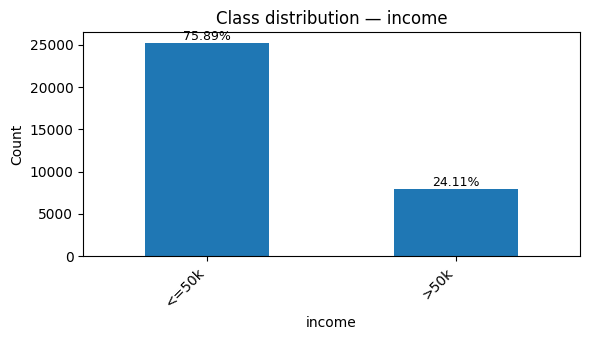


Imbalanced? -> True


In [30]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("step8_scaled.csv")

candidates = [c for c in df.columns if re.search(r"income|salary|earn|wage|pay|income_cat|income_level|>50k|<=50k", c, re.I)]
assert len(candidates) >= 1, "Set TARGET_COL manually."
TARGET_COL = candidates[0]

y = df[TARGET_COL]
vc = y.value_counts(dropna=False)
vp = (vc / vc.sum() * 100).round(2)

print("Target column:", TARGET_COL)
print("\nCounts:\n", vc)
print("\nPercentages (%):\n", vp)

plt.figure(figsize=(6,3.5))
vc.plot(kind="bar")
plt.title(f"Class distribution — {TARGET_COL}")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
for i, v in enumerate(vc.values):
    plt.text(i, v, f"{vp.values[i]}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

is_imbalanced = (len(vc) == 2 and (vc.min()/vc.sum() < 0.40)) or (len(vc) > 2 and (vc.min()/vc.sum() < 0.10))
print("\nImbalanced? ->", is_imbalanced)


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

df = pd.read_csv("step8_scaled.csv")

cands = [c for c in df.columns if re.search(r"income|salary|earn|wage|pay|income_cat|income_level|>50k|<=50k", c, re.I)]
assert len(cands) >= 1, "Set TARGET_COL manually."
TARGET_COL = cands[0]

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def freq_encode(train_s: pd.Series, valid_s: pd.Series):
    vc = train_s.value_counts(normalize=True)
    return train_s.map(vc).fillna(0.0), valid_s.map(vc).fillna(0.0), vc

Xtr = X_train[num_cols].copy()
Xte = X_test[num_cols].copy()
enc_maps = {}

for c in cat_cols:
    tr_enc, te_enc, vc = freq_encode(X_train[c].astype(str), X_test[c].astype(str))
    Xtr[f"freq_{c}"] = tr_enc.astype(float)
    Xte[f"freq_{c}"] = te_enc.astype(float)
    enc_maps[c] = vc

print("Train numeric+encoded shape:", Xtr.shape, "| Test:", Xte.shape)
print("Train class balance before:", y_train.value_counts(normalize=True).round(3).to_dict())

is_imbalanced = (y_train.value_counts(normalize=True).min() < 0.40 if y_train.nunique()==2
                 else y_train.value_counts(normalize=True).min() < 0.10)
print("Imbalanced on train? ->", is_imbalanced)

X_res, y_res = Xtr, y_train
if is_imbalanced:
    sm = SMOTE(random_state=42, k_neighbors=5)
    X_res, y_res = sm.fit_resample(Xtr, y_train)
    print("After SMOTE balance:", pd.Series(y_res).value_counts(normalize=True).round(3).to_dict())

train_out = X_res.copy()
train_out[TARGET_COL] = y_res.values
test_out = Xte.copy()
test_out[TARGET_COL] = y_test.values

train_out.to_csv("final_train_resampled.csv", index=False)
test_out.to_csv("final_test.csv", index=False)

print("\nSaved:")
print(" - final_train_resampled.csv  (use this for model training)")
print(" - final_test.csv")


Train numeric+encoded shape: (26569, 18) | Test: (6643, 18)
Train class balance before: {'<=50k': 0.759, '>50k': 0.241}
Imbalanced on train? -> True
After SMOTE balance: {'<=50k': 0.5, '>50k': 0.5}

Saved:
 - final_train_resampled.csv  (use this for model training)
 - final_test.csv
